# Strapdown Demo

In this notebook we'll walk through how to use the strapdown binary for INS evaluation and GNSS denial and degredation simulation. To start, define some helper functions and ensure that the binary is compiled as a release verion.

In [1]:
!pixi run cargo build --workspace --release

⠁ activating environment                                                            Finished ]8;;https://doc.rust-lang.org/cargo/reference/profiles.html#default-profiles\`release` profile [optimized]]8;;\ target(s) in 0.14s


In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
from haversine import haversine_vector, Unit
from matplotlib import pyplot as plt
from matplotlib.figure import Figure, SubFigure
from cartopy import crs as ccrs
from cartopy.io import img_tiles as cimgt
from typing import Optional

ROOT = Path(".").resolve()

def find_strapdown_bin() -> Path:
    if "STRAPDOWN_BIN" in os.environ:
        return Path(os.environ["STRAPDOWN_BIN"])
    exe = "strapdown-sim.exe" if sys.platform.startswith("win") else "strapdown-sim"
    cand = Path().resolve().parents[1] / "target" / "release" / exe
    if cand.exists():
        return cand
    raise FileNotFoundError("strapdown-sim not found. Build with `pixi run cargo build --workspace --release`.")


def plot_results(scenario:str, title_str:str = "") -> Figure | SubFigure:
    """Performance visualization plot helper"""
    truth = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)
    df = pd.read_csv(ROOT.joinpath("out", f'{scenario}.csv'), index_col=0, parse_dates=True)
    truth_coords = truth[["latitude", "longitude", "altitude"]].copy().to_numpy()
    df_coords = df[["latitude", "longitude", "altitude"]].copy().to_numpy()

    two_d_error = haversine_vector(truth_coords[1:, :2], df_coords[1:, :2], Unit.METERS)
    time = (df.index - df.index[0]).total_seconds()
    plt.figure(figsize=(18, 6))
    plt.plot(time[1:], two_d_error)

    plt.xlim(left=0)
    plt.ylim((0, 150))

    plt.xlabel('Time (s)')
    plt.ylabel('Haversine Error (m)')
    plt.title(f'Simulation: {title_str}')
    #plt.legend()
    plt.grid()
    return plt.gcf()


def inflate_bounds(
    min_x: float, min_y: float, max_x: float, max_y: float, inflation_percent: float
) -> tuple[float, float, float, float]:
    width = max_x - min_x
    height = max_y - min_y
    if width <= 1e-6:
        width = 0.1
    if height <= 1e-6:
        height = 0.1
    inflate_x = width * inflation_percent
    inflate_y = height * inflation_percent
    new_min_x = min_x - inflate_x
    new_min_y = min_y - inflate_y
    new_max_x = max_x + inflate_x
    new_max_y = max_y + inflate_y
    return new_min_x, new_min_y, new_max_x, new_max_y


def plot_route(cleaned_data: pd.DataFrame, output_path: str | Path, title: Optional[str] = None) -> Figure | SubFigure:
    """
    Plot the route from cleaned data and save to output_path.
    """
    west_lon = cleaned_data["longitude"].min()
    east_lon = cleaned_data["longitude"].max()
    south_lat = cleaned_data["latitude"].min()
    north_lat = cleaned_data["latitude"].max()
    west_lon, south_lat, east_lon, north_lat = inflate_bounds(west_lon, south_lat, east_lon, north_lat, 0.1)
    extent = [west_lon, east_lon, south_lat, north_lat]
    request = cimgt.GoogleTiles()
    ax = plt.axes(projection=request.crs)
    ax.set_extent(extent)  # type: ignore
    ax.add_image(request, 15)  # type: ignore
    ax.scatter(
        cleaned_data["longitude"],
        cleaned_data["latitude"],
        0.5,
        color="red",
        transform=ccrs.PlateCarree(),
    )
    if title:
        ax.set_title(title)
    plt.savefig(output_path, dpi=300)
    plt.close()
    print(f"Route plot saved to {output_path}.")
    return ax.figure

Next we'll setup the output directory for saving off results.

In [3]:
ROOT.joinpath("out").mkdir(exist_ok=True)

## Truth

First we'll develop a baseline scenario with no GNSS degradation. This will serve as the "truth" scenario against which we can compare the degraded scenarios. Due to shell and environment variable management, we'll instead invoke the simulation from Python using subprocess.run(..) instead of relying on the shell directly (ie !strapdown-sim ...)

In [4]:
from subprocess import run

In [5]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/baseline.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "none",
  "--seed", "42"], check=False)

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/baseline.csv


CompletedProcess(args=[PosixPath('/home/james/Code/strapdown-rs/target/release/strapdown-sim'), '-i', PosixPath('/home/james/Code/strapdown-rs/sim/data/test_data.csv'), '-o', 'out/baseline.csv', 'closed-loop', '--sched', 'passthrough', '--fault', 'none', '--seed', '42'], returncode=0)

In [6]:
gps = pd.read_csv(ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), index_col=0, parse_dates=True)
nav = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)

Route plot saved to /home/james/Code/strapdown-rs/examples/strapdown-sim/route_gps.png.


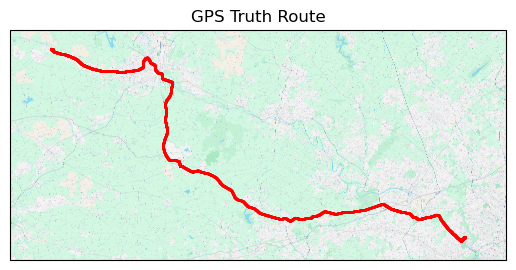

In [7]:
plot_route(gps, ROOT.joinpath("route_gps.png"), title="GPS Truth Route")

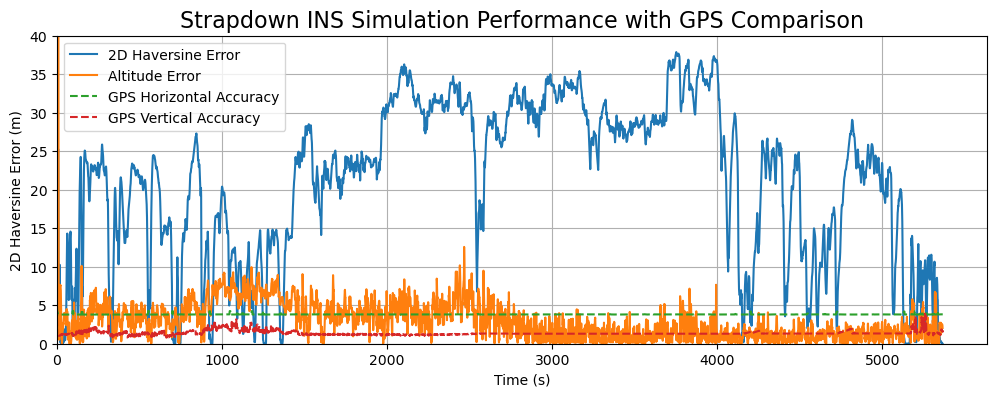

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
two_d_error = haversine_vector(gps[["latitude", "longitude"]].to_numpy()[1:, :], nav[["latitude", "longitude"]].to_numpy(), Unit.METERS)
ax.plot((nav.index - nav.index[0]).total_seconds(), two_d_error, label="2D Haversine Error")
ax.plot((nav.index - nav.index[0]).total_seconds(), abs(nav["altitude"].to_numpy() - gps["altitude"].to_numpy()[1:]), label="Altitude Error")
ax.plot((gps.index - gps.index[0]).total_seconds(), gps["horizontalAccuracy"], label="GPS Horizontal Accuracy", linestyle='--')
ax.plot((gps.index - gps.index[0]).total_seconds(), gps["verticalAccuracy"], label="GPS Vertical Accuracy", linestyle='--')
ax.set_xlim(left=0)
ax.set_ylim((0, 40))
ax.set_xlabel('Time (s)')
ax.set_ylabel('2D Haversine Error (m)')
ax.set_title('Strapdown INS Simulation Performance with GPS Comparison', fontsize=16)
ax.grid()
ax.legend()
plt.savefig(ROOT.joinpath("out", "performance.png"), dpi=300)

## Individual fault models

This section runs a test case example for each type of built in fault model.

### Degraded (AR(1)) @ full GNSS rate

Expect: smooth horizontal wander (few meters), velocity slightly noisy; innovations/NIS stay reasonable because R is inflated by r_scale.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/degraded_fullrate.csv


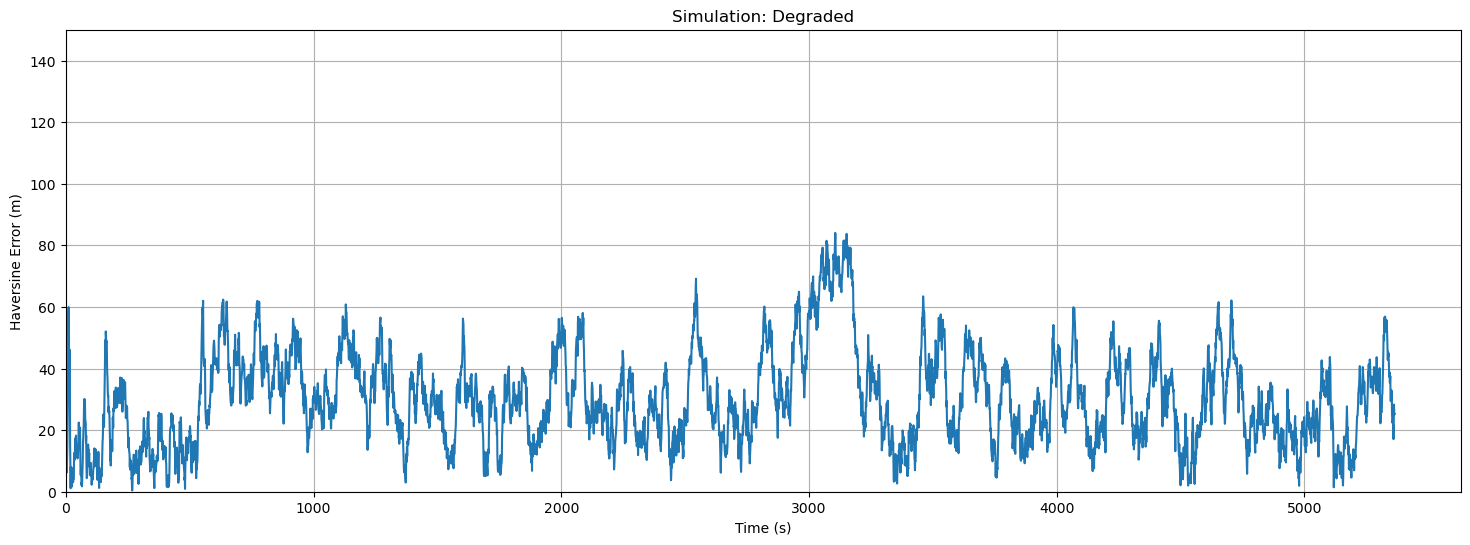

In [9]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/degraded_fullrate.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "3", "--rho-vel", "0.95", "--sigma-vel-mps", "0.3", "--r-scale", "5",
  "--seed", "42"
])
fig = plot_results("degraded_fullrate", "Degraded")
fig.savefig(ROOT.joinpath("out", "degraded_fullrate_performance.png"), dpi=300)


### Degraded (AR(1)) + reduced GNSS
Expect: “sawtooth” position error between fixes; RMS often 10–30 m depending on motion.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/degraded.csv


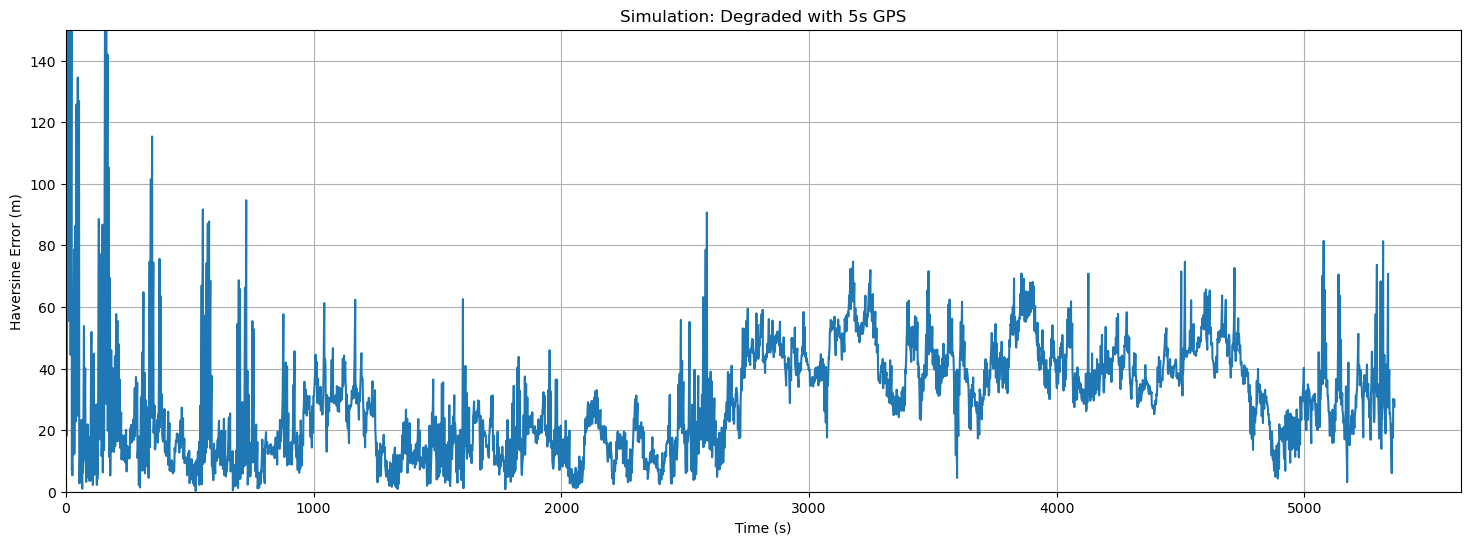

In [10]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/degraded.csv", "closed-loop",
  "--sched", "fixed", "--interval-s", "5",
  "--fault", "degraded", "--rho-pos", "0.99", "--sigma-pos-m", "3", "--rho-vel", "0.95", "--sigma-vel-mps", "0.3", "--r-scale", "5",
  "--seed", "42"
])

fig = plot_results("degraded", "Degraded with 5s GPS")
fig.savefig(ROOT.joinpath("out", "degraded_performance.png"), dpi=300)


### SlowBias (soft spoof) @ 1 Hz GNSS

Expect: steady north drift (~2 cm/s); lat/lon error grows roughly linearly with time; velocities biased by (0.02, 0.0) m/s.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/slowbias.csv


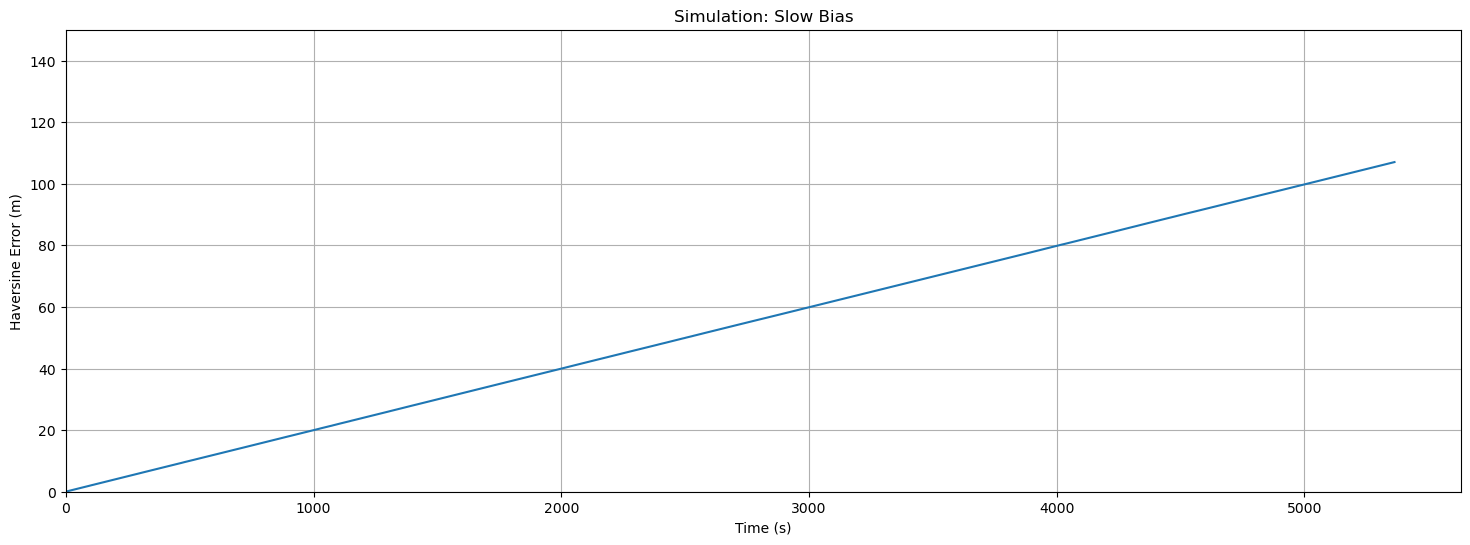

In [11]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/slowbias.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "slowbias", "--drift-n-mps", "0.02", "--drift-e-mps", "0.00", "--q-bias", "1e-6", "--rotate-omega-rps", "0.0",
  "--seed", "42"
])

fig = plot_results("slowbias", "Slow Bias")
fig.savefig(ROOT.joinpath("out", "slowbias_performance.png"), dpi=300)


### SlowBias with slow rotation (soft curved spoof)

Expect: drift direction slowly rotates (~0.057°/s); lateral error forms an arc.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/slowbias_rot.csv


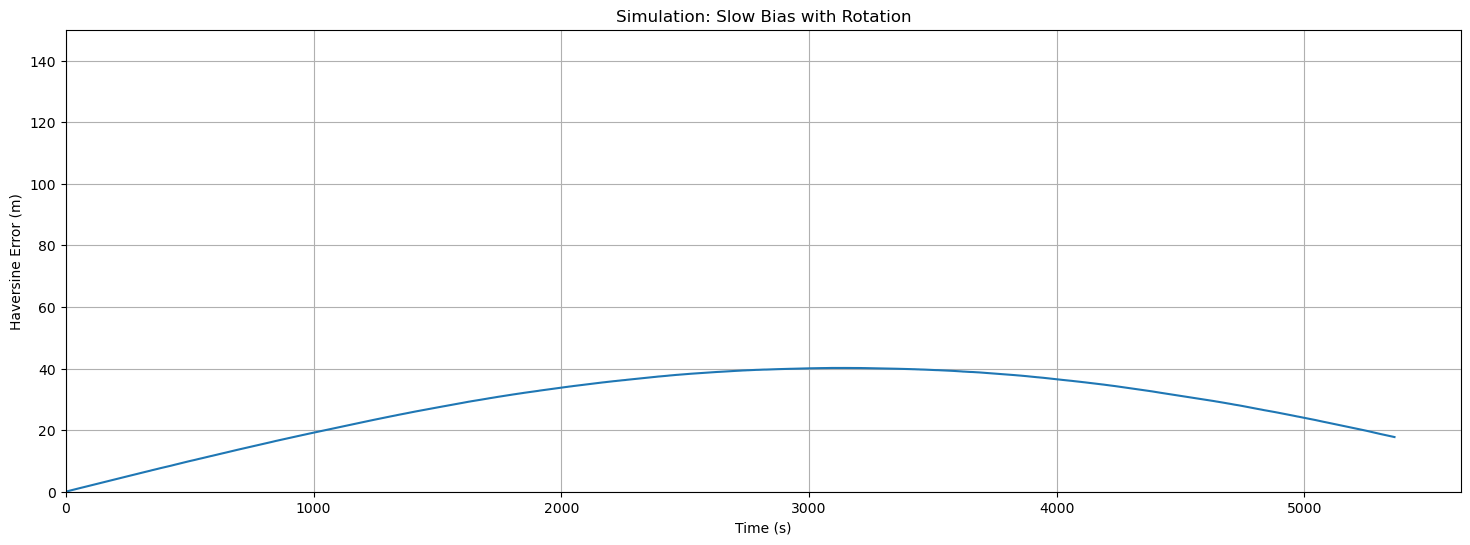

In [12]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/slowbias_rot.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "slowbias", "--drift-n-mps", "0.02", "--drift-e-mps", "0.00", "--q-bias", "5e-6", "--rotate-omega-rps", "1e-3",
  "--seed", "42"
])

fig = plot_results("slowbias_rot", "Slow Bias with Rotation")
fig.savefig(ROOT.joinpath("out", "slowbias_rot_performance.png"), dpi=300)


### Hijack (hard offset) 

A spoofing attack occurs for a 60 second window starting at t=120 seconds

Expect: abrupt ~50 m north offset only inside [120, 180] s; returns to nominal after.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/hijack.csv


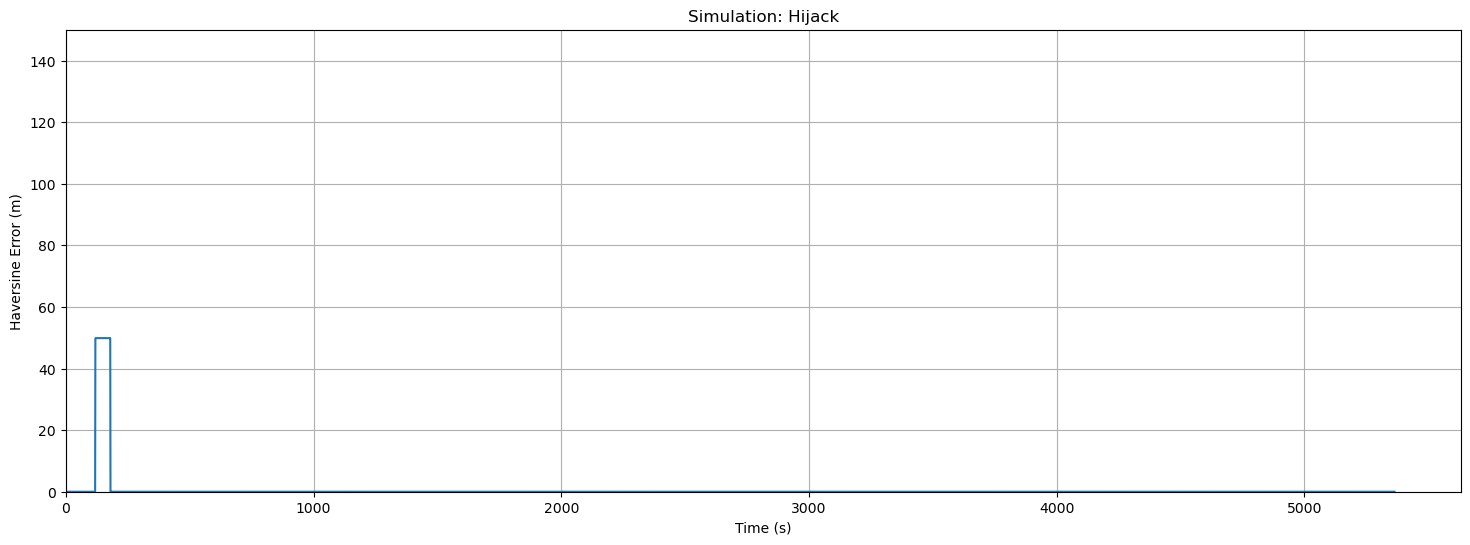

In [13]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/hijack.csv", "closed-loop",
  "--sched", "passthrough",
  "--fault", "hijack", "--hijack-start-s", "120", "--hijack-duration-s", "60", "--hijack-offset-n-m", "50", "--hijack-offset-e-m", "0",
  "--seed", "42"
])

fig = plot_results("hijack", "Hijack")
fig.savefig(ROOT.joinpath("out", "hijack_performance.png"), dpi=300)


## Scheduler-only effects 

These fault conditions only concern the *availability* of GNSS signals. The signal itself is not corrupted just intermittently or periodically unavailable or provided at a much reduced rate.

### Reduced rate only, no fault

Expect: INS drift between fixes; error clamps at each 10 s update.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.94%...Done!
Results written to out/sched.csv


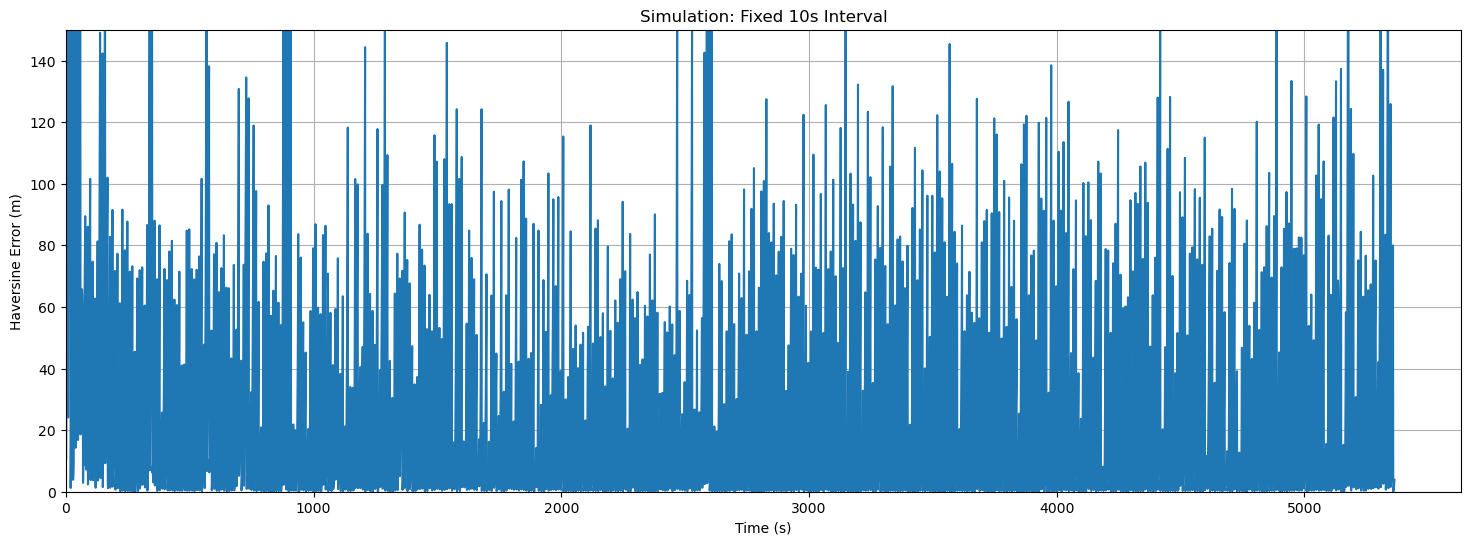

In [14]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/sched.csv", "closed-loop",
  "--sched", "fixed", "--interval-s", "10",
  "--fault", "none",
  "--seed", "42"
])

fig = plot_results("sched", "Fixed 10s Interval")
fig.savefig(ROOT.joinpath("out", "sched_performance.png"), dpi=300)

### Duty-cycle outages

Expect: growing error during OFF windows; recovery during ON; repeat.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.94%...Done!
Results written to out/duty.csv


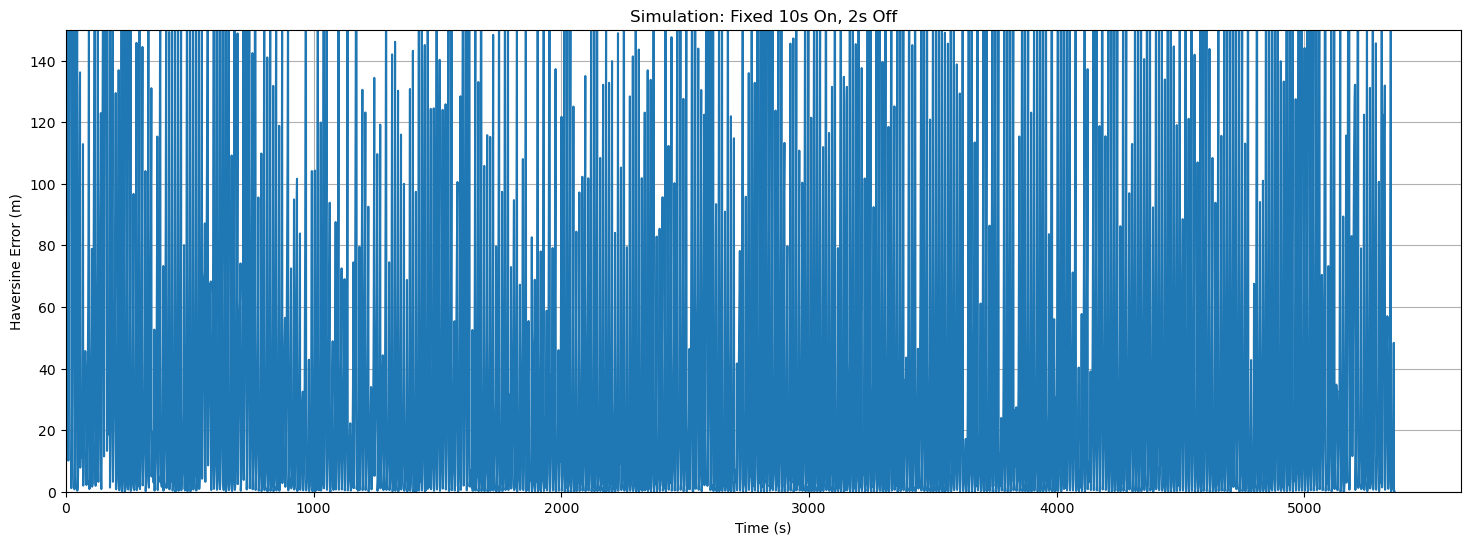

In [15]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/duty.csv", "closed-loop",
  "--sched", "duty", "--on-s", "10", "--off-s", "2", "--duty-phase-s", "1",
  "--fault", "none",
  "--seed", "42"
])

fig = plot_results("duty", "Fixed 10s On, 2s Off")
fig.savefig(ROOT.joinpath("out", "duty_performance.png"), dpi=300)


## Combination Scenarios

Degraded + SlowBias (soft spoof under poor SNR) + 10 s rate

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.97%...Done!
Results written to out/combo.csv


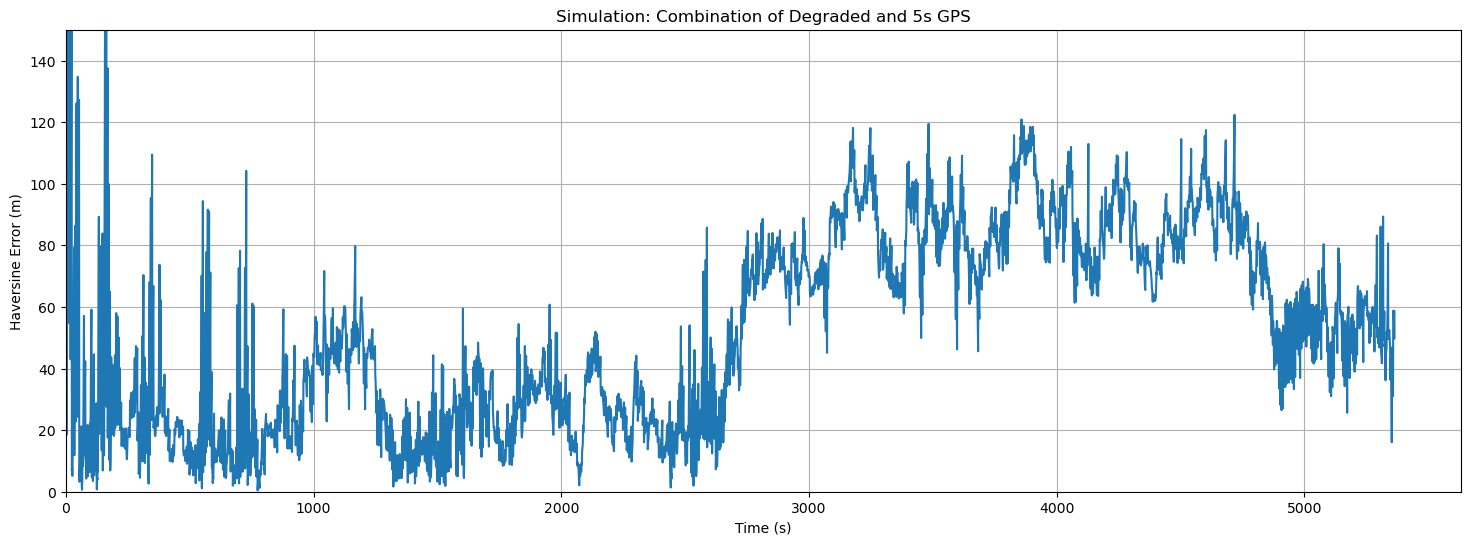

In [16]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/combo.csv", "closed-loop",
  "--sched", "fixed", "--interval-s", "5",
  "--fault", "degraded", "--rho-pos", "0.995", "--sigma-pos-m", "4", "--rho-vel", "0.97", "--sigma-vel-mps", "0.35", "--r-scale", "5",
  "--seed", "42"
])

fig = plot_results("combo", "Combination of Degraded and 5s GPS")
fig.savefig(ROOT.joinpath("out", "combo_performance.png"), dpi=300)


### Duty-cycle outages + Hijack window (stress)

Expect: large jumps inside hijack window, plus drift during OFF periods.

Read 5366 records from /home/james/Code/strapdown-rs/sim/data/test_data.csv
Processing data 99.98%...Done!
Results written to out/combo_duty_hijack.csv


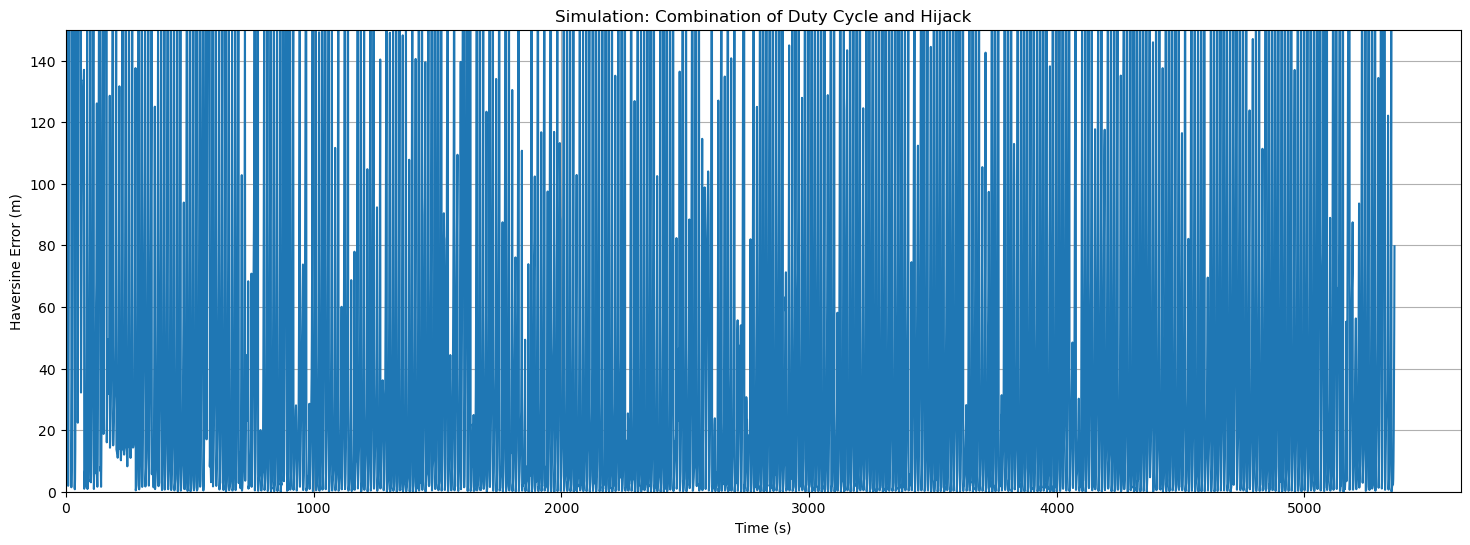

In [17]:
run([find_strapdown_bin(), "-i", ROOT.parents[1].joinpath("sim", "data", "test_data.csv"), "-o", "out/combo_duty_hijack.csv", "closed-loop",
  "--sched", "duty", "--on-s", "10", "--off-s", "3", "--duty-phase-s", "0",
  "--fault", "hijack", "--hijack-start-s", "150", "--hijack-duration-s", "120", "--hijack-offset-n-m", "10", "--hijack-offset-e-m", "10",
  "--seed", "42"
])

fig = plot_results("combo_duty_hijack", "Combination of Duty Cycle and Hijack")
fig.savefig(ROOT.joinpath("out", "combo_duty_hijack_performance.png"), dpi=300)


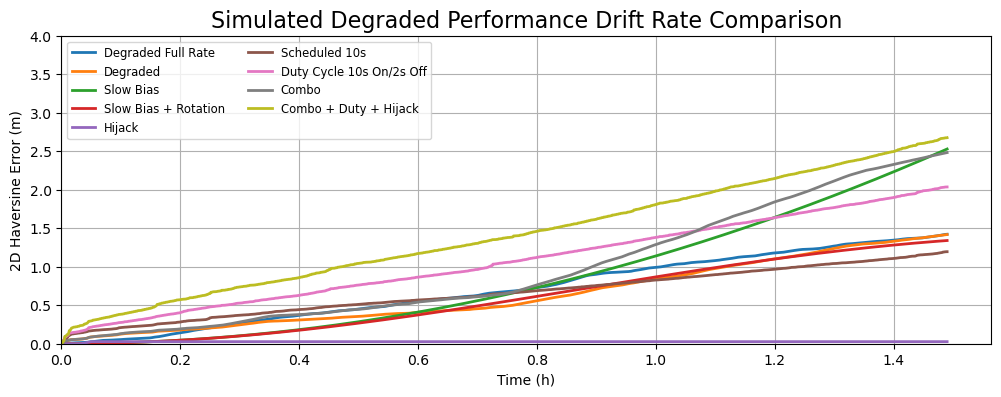

In [18]:
combo_duty_hijack = pd.read_csv(ROOT.joinpath("out", "combo_duty_hijack.csv"), index_col=0, parse_dates=True)
combo = pd.read_csv(ROOT.joinpath("out", "combo.csv"), index_col=0, parse_dates=True)
degraded_fullrate = pd.read_csv(ROOT.joinpath("out", "degraded_fullrate.csv"), index_col=0, parse_dates=True)
degraded = pd.read_csv(ROOT.joinpath("out", "degraded.csv"), index_col=0, parse_dates=True)
slowbias = pd.read_csv(ROOT.joinpath("out", "slowbias.csv"), index_col=0, parse_dates=True)
slowbias_rot = pd.read_csv(ROOT.joinpath("out", "slowbias_rot.csv"), index_col=0, parse_dates=True)
hijack = pd.read_csv(ROOT.joinpath("out", "hijack.csv"), index_col=0, parse_dates=True)
sched = pd.read_csv(ROOT.joinpath("out", "sched.csv"), index_col=0, parse_dates=True)
duty = pd.read_csv(ROOT.joinpath("out", "duty.csv"), index_col=0, parse_dates=True)
baseline = pd.read_csv(ROOT.joinpath("out", "baseline.csv"), index_col=0, parse_dates=True)

combo_duty_hijack_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), combo_duty_hijack[["latitude", "longitude"]].to_numpy(), Unit.METERS)
combo_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), combo[["latitude", "longitude"]].to_numpy(), Unit.METERS)
degraded_fullrate_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), degraded_fullrate[["latitude", "longitude"]].to_numpy(), Unit.METERS)
degraded_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), degraded[["latitude", "longitude"]].to_numpy(), Unit.METERS)
slowbias_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), slowbias[["latitude", "longitude"]].to_numpy(), Unit.METERS)
slowbias_rot_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), slowbias_rot[["latitude", "longitude"]].to_numpy(), Unit.METERS)
hijack_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), hijack[["latitude", "longitude"]].to_numpy(), Unit.METERS)
sched_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), sched[["latitude", "longitude"]].to_numpy(), Unit.METERS)
duty_error = haversine_vector(nav[["latitude", "longitude"]].to_numpy(), duty[["latitude", "longitude"]].to_numpy(), Unit.METERS)

# get cumulative errors
combo_duty_hijack_error_cum = combo_duty_hijack_error.cumsum()
combo_error_cum = combo_error.cumsum()
degraded_fullrate_error_cum = degraded_fullrate_error.cumsum()
degraded_error_cum = degraded_error.cumsum()
slowbias_error_cum = slowbias_error.cumsum()
slowbias_rot_error_cum = slowbias_rot_error.cumsum()
hijack_error_cum = hijack_error.cumsum()
sched_error_cum = sched_error.cumsum()
duty_error_cum = duty_error.cumsum()

time = (nav.index - nav.index[0]).total_seconds() 
distance_traveled = haversine_vector(gps[["latitude", "longitude"]].to_numpy()[:-1, :], gps[["latitude", "longitude"]].to_numpy()[1:, :], Unit.METERS).sum()

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(time / 3600, degraded_fullrate_error_cum / distance_traveled, label="Degraded Full Rate", linestyle="-", linewidth=2)
ax.plot(time / 3600, degraded_error_cum / distance_traveled, label="Degraded", linestyle="-", linewidth=2)
ax.plot(time / 3600, slowbias_error_cum / distance_traveled, label="Slow Bias", linestyle="-", linewidth=2)
ax.plot(time / 3600, slowbias_rot_error_cum / distance_traveled, label="Slow Bias + Rotation", linestyle="-", linewidth=2)
ax.plot(time / 3600, hijack_error_cum / distance_traveled, label="Hijack", linestyle="-", linewidth=2)
ax.plot(time / 3600, sched_error_cum / distance_traveled, label="Scheduled 10s", linestyle="-", linewidth=2)
ax.plot(time / 3600, duty_error_cum / distance_traveled, label="Duty Cycle 10s On/2s Off", linestyle="-", linewidth=2)
ax.plot(time / 3600, combo_error_cum / distance_traveled, label="Combo", linestyle="-", linewidth=2)
ax.plot(time / 3600, combo_duty_hijack_error_cum / distance_traveled, label="Combo + Duty + Hijack", linestyle="-", linewidth=2)
ax.set_xlim(left=0)
ax.set_ylim((0, 4))
ax.set_xlabel('Time (h)')
ax.set_ylabel('2D Haversine Error (m)')
ax.set_title('Simulated Degraded Performance Drift Rate Comparison', fontsize=16)
ax.grid()
ax.legend(loc='upper left', fontsize='small', ncol=2)
plt.savefig(ROOT.joinpath("out", "performance_comparison.png"), dpi=300)


In [19]:
print(f"Total distance traveled: {distance_traveled/1000:.2f} km")

Total distance traveled: 113.62 km
